In [1]:
import os
import random
import sys

import time

import yaml

from pathlib import Path

from copy import deepcopy

import numpy as np
import math

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image, ImageReadMode
import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

from pytorch_model_summary import summary

from fLossFunctions import v8DetectionLoss
from fValidation import v8DetectionValidator

from collections import defaultdict
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

import pandas as pd

from torch.ao.quantization import QuantStub, DeQuantStub

In [2]:
params = {
    "data_dir": 'D:/Datasets/coco', #"/media/pipeh/Data/Datasets/coco", # "D:/Datasets/coco",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "save_pth": "checkpoint/coco",
    "batch_size": 32,
    "img_size": 320,
    "mosaic": False,
    "mixup_thr": 0.,
    "reg_max": 4,
}

## Build datasets

In [3]:
class DetectionDataset(Dataset):
    """
    SuperClass with pytorch Dataset methods to manage an object detection dataset, loading its images
    with its labels and applying the basic data augmentation pipelines.
    
    Args:
        args (dict): script hyper parameters and arguments.
        partition (string): Dataset mode for train or test partition and data augmentations.
        transform (Albumentation Compose): Data augmentation pipeline for images in train or test.
    
    Attributes:
        mode (String): dataset mode: train or test.
        subset_images (string): image dataset subset folder name.
        subset_labels (string): labels dataset subset folder name.
        mosaic (bool): flag if use mosaic images.
        transform (Albumentation Compose): data augmentation pipeline.
        img_size (int): image size w,h to resize images.
        file_ids (list): names of the files of the images.
        
    Methods:
        __len__(self): return the lenght of dataset subset.
        __getitem__(self, idx): return a batch composed by images, its bboxes and classes labels for each box, depending if
                                mixup augmentation is true.
        load_image(self, idx): load and return a single sample composed by an image, its bboxes and classes labels for each box.
    """
    
    def __init__(self, args, partition=None, transform=None):
        super(DetectionDataset, self).__init__()
        self.params = args
        self.mode = partition
        self.img_size = args["img_size"]
        self.mosaic = args["mosaic"]
        self.transform = transform
        self.data_dir = self.params["data_dir"]
        
        self.subset_images = self.subset_labels = ''
        if self.mode == 'train':
            if self.mosaic == True:
                self.subset_images += 'train2017_mosaic_depth'
                self.subset_labels += 'train2017_mosaic_depth'            
            else:
                self.subset_images += 'train2017'
                self.subset_labels += 'train2017_depth'                
        else:
            self.subset_images += 'val2017'
            self.subset_labels += 'val2017_depth'
        
        self.file_ids = os.listdir(f'{self.data_dir}/labels/{self.subset_labels}')
        self.file_ids.sort()
        
    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        image, bboxes, labels, depths = self.load_image(idx)
        return image, bboxes, labels, depths
        
    def load_image(self, idx):
        file_name = self.file_ids[idx]
        bboxes = []
        labels = []
        depths = []
        image = read_image(f'{self.data_dir}/images/{self.subset_images}/{file_name[:-4]}.jpg', ImageReadMode.RGB)
        with open(f'{self.data_dir}/labels/{self.subset_labels}/{file_name}', 'r') as f:
            for line in f.readlines():
                line_data = list(map(float, line.strip().split()))
                labels.append(int(line_data[0]))
                bboxes.append(line_data[1:5])
                depths.append(line_data[5])
        transformed = self.transform(image=np.array(image.permute(1,2,0), np.float32) / 255., 
                                     bboxes=bboxes, 
                                     class_labels=labels)
        image = transformed['image']
        bboxes = transformed['bboxes']
        labels = transformed['class_labels']
        bboxes = torch.tensor(bboxes)
        labels = torch.tensor(labels).unsqueeze(dim=-1)
        depths = torch.tensor(depths).unsqueeze(dim=-1)
        return image, bboxes, labels, depths

In [4]:
class ProcessBatch(object):
    """
    Preprocessing class that takes a list of tuples of images, bboxes and labels and arranges them as a batch of
    given lenght, and applies MixUp augmentation if a random probability surprass a threshold.
    
    Attributes:
        n_max_boxes (int): maxium number of zeros batch padding.
        thr (float): threshold to apply mixup augmentation
        
    Methods_
        __call__(self, batch): return a batched set of images, bounding boxes and labels.
        pad_batch(self, batch): return a batched set of images, bounding boxes and labels.
        mixup_batch(self, batch): return a batched set of images, bounding boxes and labels with MixUp augmentation
                                with its same batch but randomly shuffled.
                                
    """
    def __init__(self, thr=0.5):
        self.n_max_boxes = 128
        self.n_max_boxes_mixup = 256
        self.thr = thr
        
    def __call__(self, batch):
        if random.random() < self.thr:
            images, bboxes, labels, depths = self.mixup_batch(batch)
            return images, bboxes, labels, depths
        else:
            images, bboxes, labels, depths = self.normal_batch(batch)
            return images, bboxes, labels, depths

    def normal_batch(self, batch):
        img_tuple, bboxes_tuple, labels_tuple, depths_tuple = zip(*batch)
        images  = torch.stack(list(img_tuple), dim=0)
        bboxes = torch.tensor([])
        labels = torch.tensor([])
        depths = torch.tensor([])
        for box, label, depth in zip(bboxes_tuple, labels_tuple, depths_tuple):
            box, label, depth = self.pad_batch(box, label, depth, self.n_max_boxes)
            bboxes = torch.cat([bboxes, box.unsqueeze(0)], dim=0)
            labels = torch.cat([labels, label.unsqueeze(0)], dim=0)
            depths = torch.cat([depths, depth.unsqueeze(0)], dim=0)
        return images, bboxes, labels, depths
    
    def mixup_batch(self, batch):
        img_x, bboxes_x, labels_x, depths_x = zip(*batch)
        batch = list(batch)
        batch.append(batch.pop(0))
        img_y, bboxes_y, labels_y, depths_y = zip(*batch)
        img_x  = torch.stack(list(img_x), dim=0)
        img_y  = torch.stack(list(img_y), dim=0)
        alpha = (0.6 - 0.4) * torch.rand(img_x.size(0), 1, 1, 1) + 0.4
        img = alpha * img_x + (1 - alpha) * img_y
        bboxes = torch.tensor([])
        labels = torch.tensor([])
        depths = torch.tensor([])
        for boxA,boxB,labelA,labelB,depthA,depthB in zip(bboxes_x, bboxes_y, labels_x, labels_y, depths_x, depths_y):
            box = torch.cat([boxA, boxB], dim=0)
            label = torch.cat([labelA, labelB], dim=0)
            depth = torch.cat([depthA, depthB], dim=0)
            box, label, depth = self.pad_batch(box, label, depth, self.n_max_boxes_mixup)
            bboxes = torch.cat([bboxes, box.unsqueeze(0)], dim=0)
            labels = torch.cat([labels, label.unsqueeze(0)], dim=0)
            depths = torch.cat([depths, depth.unsqueeze(0)], dim=0)
        return img, bboxes, labels, depths
    
    def pad_batch(self, bboxes, labels, depths, nmax):
        bs = bboxes.shape[0]
        n = nmax - bs
        if n>0:
            bboxes = torch.cat([bboxes, torch.zeros(n,4)])
            labels = torch.cat([labels, torch.zeros(n,1)])
            depths = torch.cat([depths, torch.zeros(n,1)])
        elif n<0:
            bboxes = bboxes[:nmax]
            labels = labels[:nmax]
            depths = depths[:nmax]
        return bboxes, labels, depths

In [5]:
def build_dataloader(args, transforms):
    """
    Function to build dataset given a directory path and a set of transforms pipeline.
    
    Args:
        args (dict): script hyper parameters and arguments.
        transforms (dict): Different data augmentation pipelines for images in train or test.
        
    Return:
        dataset (Dataset): the builded dataset of a given subset.
        dataloader (Dataloader): the dataloader method for the dataset.
    """
    dataset = dict()
    dataloader = dict()
    transform = transforms
    for x in ['train', 'val']:
        dataset[x] = DetectionDataset(
            args,
            partition=x,
            transform=transform[x]
        )
        if x == 'train':
            preprocces_batch = ProcessBatch(thr=args["mixup_thr"])
        else:
            preprocces_batch = ProcessBatch(thr=0.)            
        dataloader[x] = DataLoader(
            dataset[x],
            batch_size=args["batch_size"],
            collate_fn=preprocces_batch,
            #num_workers=4,
            shuffle=True,
        )    
    return dataset, dataloader

In [6]:
data_transform = dict()
data_transform = {
    'train': A.Compose([
        A.Resize (params['img_size'], params['img_size']),
        A.ColorJitter (hue=0.3, p=0.5),
        A.HorizontalFlip (p=0.5),
        ToTensorV2 (),
    ], bbox_params=A.BboxParams(format='coco',
                                min_area=0.0,
                                min_visibility=0.0,
                                label_fields=['class_labels'])),
    'val': A.Compose([
        A.Resize (params['img_size'], params['img_size']),
        ToTensorV2 (),
    ], bbox_params=A.BboxParams(format='coco',
                                label_fields=['class_labels'])),
}

In [7]:
dataset, dataloader = build_dataloader(params, data_transform)
dataset_sizes = {x: len(dataset[x]) for x in ['train','val']}
print(f"dataset_sizes {dataset_sizes}")

with open(f'{params["data_dir"]}/coco.yaml') as f:
    classes = yaml.safe_load(f)['names']
nclasses = len(classes)
print(f'number of classes: {nclasses} \nclasses: {[v for x,v in classes.items()]}')

dataset_sizes {'train': 117266, 'val': 4952}
number of classes: 80 
classes: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [8]:
def visualize_coco_bbox(img, bbox, class_name, depth, thickness=2):
    """ Draw a single bounding box on the image. """
    BOX_COLOR = (255, 0, 0) # Red
    TEXT_COLOR = (255, 255, 255) # White

    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    cv2.putText(
        img,
        text=str(depth[0]),
        org=(x_min, y_min + int(2.5 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

In [9]:
def visualize_dataset(dataloader, category_id_to_name):
    """
    Shows a single image with its corresponding labels for the given dataloader
    dataset method.
    
    Args:
        dataloader (Dataloader): dataloader of the dataset subset to extract sample.
        category_id_to_name (dict): name of each classes corresponding to the label index.
    """
    image, bboxes, category_ids, depths = next(iter(dataloader))
    image = image[0].unsqueeze(0)
    bboxes = bboxes[0].unsqueeze(0)
    category_ids = category_ids[0].unsqueeze(0)
    depths = depths[0].unsqueeze(0)
    mask_gt = bboxes.sum(2, keepdim=True).gt_(0)
    bs = bboxes.shape[0]
    bboxes = bboxes[mask_gt.expand(-1, -1, 4).bool()].view(bs, -1, 4)
    category_ids = category_ids[mask_gt.bool()].view(bs, -1, 1)
    depths = depths[mask_gt.bool()].view(bs, -1, 1)
    img = image[0].permute(1,2,0).numpy().copy()
    for bbox, category_id, depth in zip(bboxes.numpy()[0], category_ids.numpy()[0], depths.numpy()[0]):
        class_name = category_id_to_name[category_id[0]]
        img = visualize_coco_bbox(img, bbox, class_name, depth)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


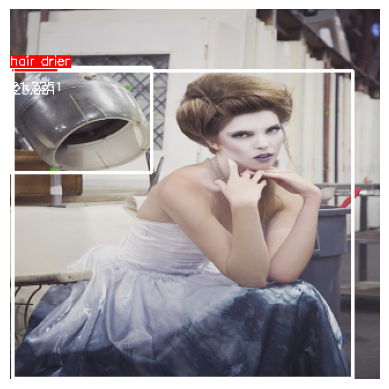

In [10]:
visualize_dataset(dataloader['val'], classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


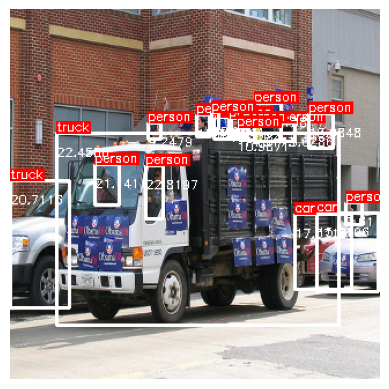

In [11]:
visualize_dataset(dataloader['train'], classes)

## Build inference functions

In [12]:
class MetricMonitor:
    """
    Metric Monitor class to show a loading bar along training to follow-up
    in-time proccesed batch and epoch, with its corresponding metrics.
    """
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val, updated=False):
        metric = self.metrics[metric_name]
        metric["val"] += val
        metric["count"] += 1
        if updated == False:
            metric["avg"] = metric["val"] / metric["count"]
        else:
            metric["avg"] = val

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [13]:
def ltwh2xyxy(x):
    """
    It converts the bounding box from [x1, y1, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 2] = x[:, 2] + x[:, 0]  # width
    y[:, 3] = x[:, 3] + x[:, 1]  # height
    return y

def xyxy2ltwh(x):
    """
    Convert nx4 bounding boxes from [x1, y1, x2, y2] to [x1, y1, w, h], where xy1=top-left, xy2=bottom-right
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

def xywh2xyxy(x):
    """
    Convert bounding box coordinates from (x, y, width, height) format to (x1, y1, x2, y2) format where (x1, y1) is the
    top-left corner and (x2, y2) is the bottom-right corner.

    Args:
        x (np.ndarray | torch.Tensor): The input bounding box coordinates in (x, y, width, height) format.
    Returns:
        y (np.ndarray | torch.Tensor): The bounding box coordinates in (x1, y1, x2, y2) format.
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

In [14]:
class DFL(nn.Module):
    """
    Integral module of Distribution Focal Loss (DFL).
    Proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    """
    def __init__(self, c1=16, device='cpu'):
        """Initialize a convolutional layer with a given number of input channels."""
        super(DFL, self).__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False).to(device)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        """Applies a transformer layer on input tensor 'x' and returns a tensor."""
        b, c, a = x.shape  # batch, channels, anchors
        return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(b, 4, a)

In [15]:
class Inference(nn.Module):
    def __init__(self, nclasses=1, stride=None, reg_max=1, device='cpu'):
        super(Inference, self).__init__()
        self.stride = stride
        self.nc = nclasses
        self.reg_max = reg_max
        self.no = self.reg_max*4 + nclasses + 1
        self.dfl = DFL(self.reg_max, device=device) #if self.reg_max > 1 else nn.Identity()
        
    def forward(self, feats):
        # Extract predictions from each head at different strides
        pred_distri, pred_scores, pred_depth = torch.cat([xi.view(feats[0].shape[0], self.no, -1) for xi in feats], 2).split((self.reg_max*4, self.nc, 1), 1)
        pred_scores = pred_scores.permute(0, 1, 2).contiguous() # (b, nc, h*w)
        pred_distri = pred_distri.permute(0, 1, 2).contiguous() # (b, 4*reg_max, h*w)
        pred_depth = pred_depth.permute(0, 1, 2).contiguous() # (b, 1, h*w)
        # Get anchor point centers from output grids and its corresponding stride
        anchors, strides = (x.transpose(0, 1) for x in self.make_anchors(feats, self.stride, 0.5))
        # Decode reg_max*4 prediction to cxywh bounding box prediction
        dbox = self.dist2bbox(self.dfl(pred_distri), anchors.unsqueeze(0), xywh=True, dim=1).clamp_(0.) * strides
        y = torch.cat((dbox, pred_scores.sigmoid(), pred_depth), 1) # (bs, 4 + nclasses + depth, h*w)
        return y
    
    def dist2bbox(self, distance, anchor_points, xywh=True, dim=-1):
        """Transform distance(ltrb) to box(xywh or xyxy).
                width and height of bounding box are in range [0, 2*(self.reg_max-1)] owing to (x2y2-x1y1=rb+lt) 
        """
        lt, rb = distance.chunk(2, dim) # lt and rb is in range[0, self.reg_max-1] 
        x1y1 = anchor_points - lt
        x2y2 = anchor_points + rb
        if xywh:
            c_xy = (x1y1 + x2y2) / 2
            wh = x2y2 - x1y1
            return torch.cat((c_xy, wh), dim)  # xywh bbox
        return torch.cat((x1y1, x2y2), dim)  # xyxy bbox

    def make_anchors(self, feats, strides, grid_cell_offset=0.5):
        """Generate anchors from features."""
        anchor_points, stride_tensor = [], []
        assert feats is not None
        dtype, device = feats[0].dtype, feats[0].device
        for i, stride in enumerate(strides):
            _, _, h, w = feats[i].shape
            sx = torch.arange(end=w, device=device, dtype=dtype) + grid_cell_offset  # shift x
            sy = torch.arange(end=h, device=device, dtype=dtype) + grid_cell_offset  # shift y
            sy, sx = torch.meshgrid(sy, sx, indexing='ij')
            anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
            stride_tensor.append(torch.full((h * w, 1), stride, dtype=dtype, device=device))
        return torch.cat(anchor_points), torch.cat(stride_tensor)

In [16]:
class InferenceYolo(nn.Module):
    def __init__(self, nclasses=1, stride=None, reg_max=16, device='cpu'):
        super(InferenceYolo, self).__init__()
        self.stride = stride
        self.nc = nclasses
        self.reg_max = reg_max
        self.no = self.reg_max*4 + nclasses
        self.dfl = DFL(self.reg_max).to(device) #if self.reg_max > 1 else nn.Identity()
        
    def forward(self, feats):
        # Extract predictions from each head at different strides
        pred_distri, pred_scores = torch.cat([xi.view(feats[0].shape[0], self.no, -1) for xi in feats], 2).split((self.reg_max * 4, self.nc), 1)
        pred_scores = pred_scores.permute(0, 1, 2).contiguous()
        pred_distri = pred_distri.permute(0, 1, 2).contiguous()
        # Get anchor point centers from output grids and its corresponding stride
        anchors, strides = (x.transpose(0, 1) for x in self.make_anchors(feats, self.stride, 0.5))
        # Decode reg_max*4 prediction to cxywh bounding box prediction
        dbox = self.dist2bbox(self.dfl(pred_distri), anchors.unsqueeze(0), xywh=True, dim=1).clamp_(0.) * strides
        y = torch.cat((dbox, pred_scores.sigmoid()), 1) # (bs, 4 + nclasses, h*w)
        return y
    
    def dist2bbox(self, distance, anchor_points, xywh=True, dim=-1):
        """Transform distance(ltrb) to box(xywh or xyxy).
                width and height of bounding box are in range [0, 2*(self.reg_max-1)] owing to (x2y2-x1y1=rb+lt) 
        """
        lt, rb = distance.chunk(2, dim) # lt and rb is in range[0, self.reg_max-1] 
        x1y1 = anchor_points - lt
        x2y2 = anchor_points + rb
        if xywh:
            c_xy = (x1y1 + x2y2) / 2
            wh = x2y2 - x1y1
            return torch.cat((c_xy, wh), dim)  # xywh bbox
        return torch.cat((x1y1, x2y2), dim)  # xyxy bbox

    def make_anchors(self, feats, strides, grid_cell_offset=0.5):
        """Generate anchors from features."""
        anchor_points, stride_tensor = [], []
        assert feats is not None
        dtype, device = feats[0].dtype, feats[0].device
        for i, stride in enumerate(strides):
            _, _, h, w = feats[i].shape
            sx = torch.arange(end=w, device=device, dtype=dtype) + grid_cell_offset  # shift x
            sy = torch.arange(end=h, device=device, dtype=dtype) + grid_cell_offset  # shift y
            sy, sx = torch.meshgrid(sy, sx, indexing='ij')
            anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
            stride_tensor.append(torch.full((h * w, 1), stride, dtype=dtype, device=device))
        return torch.cat(anchor_points), torch.cat(stride_tensor)

In [17]:
def non_max_suppression(
        pred,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nc=0,  # number of classes (optional)
        max_time_img=0.05,
        max_nms=30000,
        max_wh=7680,
):
    """
    Perform non-maximum suppression (NMS) on a set of boxes, with support for masks and multiple labels per box.

    Arguments:
        prediction (torch.Tensor): A tensor of shape (batch_size, num_classes + 4 + num_masks, num_boxes)
            containing the predicted boxes, classes, and masks. The tensor should be in the format
            output by a model, such as YOLO.
        conf_thres (float): The confidence threshold below which boxes will be filtered out.
            Valid values are between 0.0 and 1.0.
        iou_thres (float): The IoU threshold below which boxes will be filtered out during NMS.
            Valid values are between 0.0 and 1.0.
        classes (List[int]): A list of class indices to consider. If None, all classes will be considered.
        agnostic (bool): If True, the model is agnostic to the number of classes, and all
            classes will be considered as one.
        multi_label (bool): If True, each box may have multiple labels.
        labels (List[List[Union[int, float, torch.Tensor]]]): A list of lists, where each inner
            list contains the apriori labels for a given image. The list should be in the format
            output by a dataloader, with each label being a tuple of (class_index, x1, y1, x2, y2).
        max_det (int): The maximum number of boxes to keep after NMS.
        nc (int, optional): The number of classes output by the model. Any indices after this will be considered masks.
        max_time_img (float): The maximum time (seconds) for processing one image.
        max_nms (int): The maximum number of boxes into torchvision.ops.nms().
        max_wh (int): The maximum box width and height in pixels

    Returns:
        (List[torch.Tensor]): A list of length batch_size, where each element is a tensor of
            shape (num_boxes, 6 + num_masks) containing the kept boxes, with columns
            (x1, y1, x2, y2, confidence, class, mask1, mask2, ...).
    """

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    
    prediction = pred  # (bs, 4 + nclasses + depth scalar, h*w) ; h*w = num_boxes or predicted boxes

    device = prediction.device
    mps = 'mps' in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = nc or (prediction.shape[1] - 4)  # number of classes
    nm = prediction.shape[1] - nc - 4
    mi = 4 + nc  # mask start index
    xc = prediction[:, 4:mi].amax(1) > conf_thres  # candidates (bs, h*w)

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    time_limit = 0.5 + max_time_img * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs # list with lenght=bs of (0, 4;bbox + 1;score + 1;cls + nm)
    for xi, x in enumerate(prediction):  # image index, image inference
        
        # Apply constraints
        x = x.transpose(0, -1)[xc[xi]]  # confidence (num_candidates, 4 + nclasses + nm)

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[range(len(lb)), lb[:, 0].long() + 4] = 1.0  # cls
            x = torch.cat((x, v), 0)
        
        # If none remain process next image
        if not x.shape[0]:
            continue
         
        # Detections matrix nx6 (x1y1x2y2, conf, cls)
        box, cls, mask = x.split((4, nc, nm), 1) # (num_candidates, 4), (num_candidates, n_classes), (num_candidates, nm)
        box = xywh2xyxy(box).clamp_(0.)  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        if multi_label:
            i, j = (cls > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres] # (num_candidates, 4;bbox + 1;score + 1;cls + nm)
        
        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]
        
        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        
        # Sort by confidence and remove excess boxes
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # (num_candidates, 4;bbox + 1;score + 1;cls + nm)

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes (num_candidates, 1;cls)

        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]  # (num_candidates, 4), (num_candidates, 1)

        # NMS
        i = torchvision.ops.nms(boxes, scores, iou_thres) # (num_survivor_bboxes)
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # Update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        
        if mps:
            output[xi] = output[xi].to(device)
        if (time.time() - t) > time_limit:
            print(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            #break  # time limit exceeded

    return output

In [18]:
def visualize_yolo_bbox(img, bbox, class_name, thickness=2):
    """ Draw a single bounding box on the image. """
    BOX_COLOR = (255, 0, 0) # Red
    TEXT_COLOR = (255, 255, 255) # White

    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

In [19]:
def visualize_pred(img, nms, category_id_to_name):
    """
    Shows a single image with its corresponding labels for the given dataloader
    dataset method.
    
    Args:
        img (Tensor): Shape (bs, channel, height, width) predicted image
        nms (List): Shape(detections, bbox + score + class) non-maxium suppression result on
                                        predicted boxes.
        category_id_to_name (dict): name of each classes corresponding to the label index.
    """

    prediction = nms[0].to('cpu')
    img = img[0].to('cpu').permute(1,2,0).numpy().copy()
    
    bboxes = prediction[:,:4]
    #bboxes = xywh2xyxy(bboxes).clamp_(0.)
    category_ids = prediction[:,5]
    for bbox, category_id in zip(bboxes.detach().numpy(), category_ids.detach().numpy()):
        class_name = category_id_to_name[int(category_id)]
        img = visualize_yolo_bbox(img, bbox, class_name)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

## Build detection model

In [20]:
class ConvModule(nn.Module):
    """
    Convolutional block composed of conv->batchnorm->relu. 
    """
    def __init__(self, cin=1, cout=1, k=1, s=1, p=0, device='cpu'):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(cin, cout, (k, k), stride=s, padding=p, bias=False).to(device)
        self.bn = nn.BatchNorm2d(cout, eps=0.001, momentum=0.03, affine=True, track_running_stats=True).to(device)
        self.silu = nn.SiLU(inplace=True).to(device)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.silu(x)
        return x

In [21]:
class Bottleneck(nn.Module):
    """ 
    Bottleneck block componsed of conv->conv->residual connection. 
    """
    def __init__(self, c=1, shortcut=False, device='cpu'):
        super(Bottleneck, self).__init__()
        self.conv1 = ConvModule(cin=c, cout=c//2, k=3, s=1, p=1, device=device)
        self.conv2 = ConvModule(cin=c//2, cout=c, k=3, s=1, p=1, device=device)
        self.shortcut = shortcut
        
    def forward(self, x):
        xin = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.shortcut==True:
            x = xin + x
            return x
        return x

In [22]:
class C2f(nn.Module):
    """ 
    C2f module (cross-stage partial bottleneck with two convolutions) which combines 
    high-level features with contextual information to improve detection accuracy. 
    """
    def __init__(self, cin=1, cout=1, depth=1, device='cpu'):
        super(C2f, self).__init__()
        self.cout = cout
        self.depth = depth
        self.convmodule1 = ConvModule(cin=cin, cout=cout, k=1, s=1, p=0, device=device)
        bottleneck = []
        for _ in range(depth):
            bottleneck.append(Bottleneck(c=self.cout//2, shortcut=True, device=device))
        self.bottleneck = nn.Sequential(*bottleneck)
        cin = cout//2 * (depth+2)
        self.convmodule2 = ConvModule(cin=cin, cout=cout, k=1, s=1, p=0, device=device)
        
    def forward(self, x):
        x1 = self.convmodule1(x)
        x1_1, x1_2 = torch.split(x1, self.cout//2, dim=1)
        x3 = torch.cat([x1_1, x1_2],dim=1)
        for mod in self.bottleneck:
            x2 = mod(x1_2)
            x3 = torch.cat([x3, x2], dim=1)
            x1_2 = x2
        x = self.convmodule2(x3)
        return x

In [23]:
class SPPF(nn.Module):
    """ 
    Spatial pyramid pooling fast module (SPPF) layer accelerates computation 
    by pooling features into a fixed-size map. 
    """
    def __init__(self, c=1, device='cpu'):
        super(SPPF, self).__init__()
        self.conv1 = ConvModule(cin=c, cout=c, k=1, s=1, p=0, device=device)
        self.mp1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.mp2 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.mp3 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.conv2 = ConvModule(cin=c*4, cout=c, k=1, s=1, p=0, device=device)

    def forward(self, x):
        x = self.conv1(x)
        x1 = self.mp1(x)
        x2 = self.mp2(x1)
        x3 = self.mp3(x2)
        x = torch.cat([x, x1, x2, x3], dim=1)
        x = self.conv2(x)
        return x

In [24]:
class DetectionHead(nn.Module):
    """
    Detection head module, which is decoupled to regression, classification, 
    and depth central pixel estimation tasks independently.
    """
    def __init__(self, c=1, reg_max=1, nclass=1, device='cpu'):
        super(DetectionHead, self).__init__()
        d = max(c, reg_max*4)
        self.bboxconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.bboxconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.bboxconv3 = nn.Conv2d(d, 4*reg_max, (1, 1), stride=1, padding=0, bias=False).to(device)
        self.clsconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.clsconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.clsconv3 = nn.Conv2d(d, nclass, (1, 1), stride=1, padding=0, bias=False).to(device)
        self.dptconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.dptconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.dptconv3 = nn.Conv2d(d, 1, (1, 1), stride=1, padding=0, bias=False).to(device)
      
    def forward(self, x):
        # bbox branch
        xbbox = self.bboxconv1(x)
        xbbox = self.bboxconv2(xbbox)
        xbbox = self.bboxconv3(xbbox)
        # cls branch
        xcls = self.clsconv1(x)
        xcls = self.clsconv2(xcls)
        xcls = self.clsconv3(xcls)
        # depth branch
        xdpt = self.dptconv1(x)
        xdpt = self.dptconv2(xdpt)
        xdpt = self.dptconv3(xdpt)
        
        feats = torch.cat([xbbox, xcls, xdpt], dim=1) 
        return feats

In [25]:
class ObjectDetector(nn.Module):
    """
    Object Detection model inspired on YOLOv8 from Ultralytics (https://docs.ultralytics.com/models/yolov8/#supported-tasks).
    The features maps has been divided by two respect the nano version, 
    in order to reduce model size for edge devices.
    The detection head incorportes a new feature: a decoupled head for 
    depth estimation of the central pixel of the regressed bounding boxes.
    
    Args:
        nclasses (int): number of classes in the classification task of bounding boxes.
        device (string): device to initiate and proccess weights; cpu or cuda.
    
    Attributes:
        convX (nn.Conv2d): two dimensional convolution layer to extract features along
                           different resolution maps.
        sppf (nn.Module): spatial pyramid pooling fast module.
        c2f_x (nn.Module): cross-stage partial bottleneck module.
        upsample (nn.Upsample): upsampling layer to concatenate features in the neck 
                                control connections.
        headX (nn.Module): detection head for different features resolution maps.
        
    Methods:
        forward(self, x): forward given input along detection model.
    """
    def __init__(self, nclasses=1, reg_max=1, device='cpu'):
        super(ObjectDetector, self).__init__()

        self.conv1 = ConvModule(cin=3, cout=16, k=3, s=2, p=1, device=device)
        self.conv2 = ConvModule(cin=16, cout=32, k=3, s=2, p=1, device=device)
        self.conv3 = ConvModule(cin=32, cout=64, k=3, s=2, p=1, device=device)
        self.conv4 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv5 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv6 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv7 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        
        self.sppf = SPPF(c=64, device=device)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest').to(device)

        self.c2f_1 = C2f(cin=32, cout=32, depth=1, device=device)
        self.c2f_2 = C2f(cin=64, cout=64, depth=2, device=device)
        self.c2f_3 = C2f(cin=64, cout=64, depth=2, device=device)
        self.c2f_4 = C2f(cin=64, cout=64, depth=1, device=device)
        self.c2f_5 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_6 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_7 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_8 = C2f(cin=128, cout=64, depth=1, device=device)
        
        self.head1 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        self.head2 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        self.head3 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        
        #self.inference = Inference(nclasses=nclasses, stride=torch.tensor([8,16,32]), reg_max=reg_max, device=device)
        
    def forward(self, x):

        ## ------------------------------ BACKBONE ------------------------------------
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        c2f_1 = self.c2f_1(x2)
        x3 = self.conv3(c2f_1)
        c2f_2 = self.c2f_2(x3)
        x4 = self.conv4(c2f_2)
        c2f_3 = self.c2f_3(x4)
        x5 = self.conv5(c2f_3)
        c2f_4 = self.c2f_4(x5)
        sppf = self.sppf(c2f_4)
        
        ## ------------------------------ NECK ------------------------------------
        ## process branch
        up_1 = self.upsample(sppf)
        cat_1 = torch.cat([up_1, c2f_3], dim=1)
        c2f_5 = self.c2f_5(cat_1)      
        up_2 = self.upsample(c2f_5)    
        cat_2 = torch.cat([up_2, c2f_2], dim=1)
        c2f_6 = self.c2f_6(cat_2)

        ## error feedback branch
        x6 = self.conv6(c2f_6)
        cat_3 = torch.cat([x6, c2f_5], dim=1)
        c2f_7 = self.c2f_7(cat_3)
        x7 = self.conv7(c2f_7)
        cat_4 = torch.cat([x7, sppf], dim=1)
        c2f_8 = self.c2f_8(cat_4)
    
        ## ------------------------------ HEAD ----------------------------------
        head1 = self.head1(c2f_6)
        head2 = self.head2(c2f_7)
        head3 = self.head3(c2f_8)
        
        head_detections = (head1, head2, head3)
        #y = self.inference(head_detections)
        
        return head_detections

## Load trained custom model

In [26]:
# trained model minneapple_model_152_newv10  new_mixed_ob_dpt mixed_model_157_newv1.pt
if str(params["device"]) == 'cuda':
    trained_model = torch.load('../Modelos/DOD_coco.pt').to(params["device"])
else:
    trained_model = torch.load('../Modelos/DOD_coco.pt', map_location=torch.device('cpu')).to(params["device"])

for name, param in trained_model.named_parameters():
    param.requires_grad = False
    param.grad = None
    
trained_model.eval()
print(summary(trained_model.to(params["device"]), torch.zeros((1, 3, 640, 640)).to(params["device"]), show_input=True))

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 640, 640]             464               0
       ConvModule-2     [1, 16, 320, 320]           4,672               0
              C2f-3     [1, 32, 160, 160]           5,040               0
       ConvModule-4     [1, 32, 160, 160]          18,560               0
              C2f-5       [1, 64, 80, 80]          31,168               0
       ConvModule-6       [1, 64, 80, 80]          36,992               0
              C2f-7       [1, 64, 40, 40]          31,168               0
       ConvModule-8       [1, 64, 40, 40]          36,992               0
              C2f-9       [1, 64, 20, 20]          19,808               0
            SPPF-10       [1, 64, 20, 20]          20,736               0
        Upsample-11       [1, 64, 20, 20]               0               0
             C2f-12      [1, 128, 40,

## Load yolov8n

In [27]:
# yolov8n ultralytics model
yolov8n = torch.load('../Modelos/yolov8n.pt', map_location=torch.device('cpu'))
yolomodel = yolov8n['model']
yolomodel = yolomodel.to(torch.float32).to(params["device"])
yolomodel.eval()
print(summary(yolomodel, torch.zeros((1, 3, 320, 320)).to(params["device"]), show_input=True))

-----------------------------------------------------------------------------------------------------------
      Layer (type)                                             Input Shape         Param #     Tr. Param #
            Conv-1                                        [1, 3, 320, 320]             464               0
            Conv-2                                       [1, 16, 160, 160]           4,672               0
             C2f-3                                         [1, 32, 80, 80]           7,360               0
            Conv-4                                         [1, 32, 80, 80]          18,560               0
             C2f-5                                         [1, 64, 40, 40]          49,664               0
            Conv-6                                         [1, 64, 40, 40]          73,984               0
             C2f-7                                        [1, 128, 20, 20]         197,632               0
            Conv-8                  

## Build benchmark functions

In [ ]:
with open(f'{params["data_dir"]}/coco.yaml') as f:
    classes = yaml.safe_load(f)['names']
nclasses = len(classes)

device = params["device"]
reg_max = params["reg_max"]
inference = Inference(nclasses=len(classes), stride=torch.tensor([8,16,32]), reg_max=reg_max, device=device)
inference_yolo = InferenceYolo(nclasses=len(classes), stride=torch.tensor([8,16,32]), reg_max=16, device=device)

size = params['img_size']

data_dir = params["data_dir"]
subset_images = 'val2017'

file_ids = os.listdir(f'{data_dir}/images/{subset_images}')
file_ids.sort()

In [ ]:
torch.backends.cudnn.benchmark = True

### Yolov8n benchmark

In [27]:
# yolov8n ultralytics model
yolov8n = torch.load('checkpoint/yolov8n.pt', map_location=torch.device('cpu'))
yolomodel = yolov8n['model']
yolomodel = yolomodel.to(torch.float32).to(params["device"])
yolomodel.eval()
print(summary(yolomodel, torch.zeros((1, 3, 320, 320)).to(params["device"]), show_input=True))

timers = []
for ids in file_ids*4:
    start_time = time.time()
    img = cv2.imread(f'{data_dir}/images/{subset_images}/{ids}')
    img = cv2.resize(img[...,::-1], (size,size))
    img = torch.tensor(img/255.).permute(2,0,1).unsqueeze(0).to(torch.float32).to(params['device'], non_blocking=True)
    with torch.no_grad():
        _, preds = yolomodel(img)
        y = inference_yolo(preds)
        output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, max_det=300, nc=len(classes), multi_label=False)
    end_time = time.time()
    timers.append(end_time - start_time)
    #visualize_pred(img, output, classes)

print(f"yolov8n average time per frame: {np.mean(np.array(timers))}")
del yolomodel

-----------------------------------------------------------------------------------------------------------
      Layer (type)                                             Input Shape         Param #     Tr. Param #
            Conv-1                                        [1, 3, 320, 320]             464               0
            Conv-2                                       [1, 16, 160, 160]           4,672               0
             C2f-3                                         [1, 32, 80, 80]           7,360               0
            Conv-4                                         [1, 32, 80, 80]          18,560               0
             C2f-5                                         [1, 64, 40, 40]          49,664               0
            Conv-6                                         [1, 64, 40, 40]          73,984               0
             C2f-7                                        [1, 128, 20, 20]         197,632               0
            Conv-8                  

### Custom yolov8 trained model benchmark

In [28]:
# yolov8n ultralytics model
# trained model minneapple_model_152_newv10  new_mixed_ob_dpt mixed_model_157_newv1.pt
if str(params["device"]) == 'cuda':
    trained_model = torch.load('checkpoint/new_coco_ob_dpt.pt').to(params["device"])
else:
    trained_model = torch.load('checkpoint/new_coco_ob_dpt.pt', map_location=torch.device('cpu')).to(params["device"])

for name, param in trained_model.named_parameters():
    param.requires_grad = False
    param.grad = None
    
trained_model.eval()
print(summary(trained_model.to(params["device"]), torch.zeros((1, 3, 640, 640)).to(params["device"]), show_input=True))

timers = []
for ids in file_ids*4:
    start_time = time.time()
    img = cv2.imread(f'{data_dir}/images/{subset_images}/{ids}')
    img = cv2.resize(img[...,::-1], (size,size))
    img = torch.tensor(img/255.).permute(2,0,1).unsqueeze(0).to(torch.float32).to(params['device'], non_blocking=True)
    with torch.no_grad():
        preds = trained_model(img)
        y = inference(preds)
        output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, max_det=300, nc=len(classes), multi_label=False)
    end_time = time.time()
    timers.append(end_time - start_time)
    #visualize_pred(img, output, classes)

print(f"trained model average time per frame: {np.mean(np.array(timers))}")
del trained_model

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 640, 640]             464               0
       ConvModule-2     [1, 16, 320, 320]           4,672               0
              C2f-3     [1, 32, 160, 160]           5,040               0
       ConvModule-4     [1, 32, 160, 160]          18,560               0
              C2f-5       [1, 64, 80, 80]          31,168               0
       ConvModule-6       [1, 64, 80, 80]          36,992               0
              C2f-7       [1, 64, 40, 40]          31,168               0
       ConvModule-8       [1, 64, 40, 40]          36,992               0
              C2f-9       [1, 64, 20, 20]          19,808               0
            SPPF-10       [1, 64, 20, 20]          20,736               0
        Upsample-11       [1, 64, 20, 20]               0               0
             C2f-12      [1, 128, 40,

## Results

cpu:

yolov8n average time per frame: 0.02115277626514435

trained model average time per frame: 0.017529916203022

gpu:

yolov8n average time per frame: 0.011775347363948823

trained model average time per frame: 0.011950841903686523

## Print some inferences

In [112]:
def visualize_coco_bbox(img, bbox, class_name, depth, thickness=2):
    BOX_COLOR = (0, 0, 0)
    TEXT_COLOR = (255, 0, 255) # 255, 0, 255 o  0, 255, 255
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    text_to_print = class_name + ' ' + str(np.round(depth[0],2))
    ((text_width, text_height), _) = cv2.getTextSize(text_to_print, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=text_to_print,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

def visualize_img(image, bboxes, category_ids, depths, category_id_to_name, ind=0):
    image = image[ind].unsqueeze(0)
    bboxes = bboxes[ind].unsqueeze(0)
    category_ids = category_ids[ind].unsqueeze(0)
    depths = depths[ind].unsqueeze(0)
    mask_gt = bboxes.sum(2, keepdim=True).gt_(0)
    bs = bboxes.shape[0]
    bboxes = bboxes[mask_gt.expand(-1, -1, 4).bool()].view(bs, -1, 4)
    category_ids = category_ids[mask_gt.bool()].view(bs, -1, 1)
    depths = depths[mask_gt.bool()].view(bs, -1, 1)
    img = image[0].permute(1,2,0).numpy().copy()
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)
    plt.imsave(f'Inferencias/coco/{ind}_img.png', img)
    for bbox, category_id, depth in zip(bboxes.numpy()[0], category_ids.numpy()[0], depths.numpy()[0]):
        class_name = category_id_to_name[category_id[0]]
        img = visualize_coco_bbox(img, bbox, class_name, depth)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)
    plt.imsave(f'Inferencias/coco/{ind}_gt.png', img)
    
def visualize_yolo_bbox(img, bbox, class_name, depth, thickness=2):
    BOX_COLOR = (0, 0, 0)
    TEXT_COLOR = (255, 0, 255) # 255, 0, 255 o  0, 255, 255
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    text_to_print = class_name + ' ' + str(np.round(depth,2))
    ((text_width, text_height), _) = cv2.getTextSize(text_to_print, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=text_to_print,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img
def visualize_pred(img, nms, category_id_to_name, ind=0):
    prediction = nms[ind].to('cpu')
    img = img[ind].to('cpu').permute(1,2,0).numpy().copy()
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    bboxes = prediction[:,:4]
    category_ids = prediction[:,5]
    depths = prediction[:,6]
    for bbox, category_id, depth in zip(bboxes.detach().numpy(), category_ids.detach().numpy(), depths.detach().numpy()):
        class_name = category_id_to_name[int(category_id)]
        img = visualize_yolo_bbox(img, bbox, class_name, depth)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)
    plt.imsave(f'Inferencias/coco/{ind}_DOD.png', img)
    
def visualize_yolo_bbox_2(img, bbox, class_name, thickness=2):
    BOX_COLOR = (0, 0, 0)
    TEXT_COLOR = (255, 0, 255) # 255, 0, 255 o  0, 255, 255
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    text_to_print = class_name
    ((text_width, text_height), _) = cv2.getTextSize(text_to_print, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=text_to_print,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img
def visualize_pred_yolov8n(img, nms, category_id_to_name, ind=0):
    prediction = nms[ind].to('cpu')
    img = img[ind].to('cpu').permute(1,2,0).numpy().copy()
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    bboxes = prediction[:,:4]
    category_ids = prediction[:,5]
    for bbox, category_id in zip(bboxes.detach().numpy(), category_ids.detach().numpy()):
        class_name = category_id_to_name[int(category_id)]
        img = visualize_yolo_bbox_2(img, bbox, class_name)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)
    plt.imsave(f'Inferencias/coco/{ind}_yolov8n.png', img)

GT
DOD
yolov8n


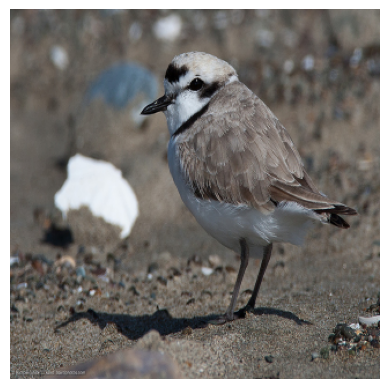

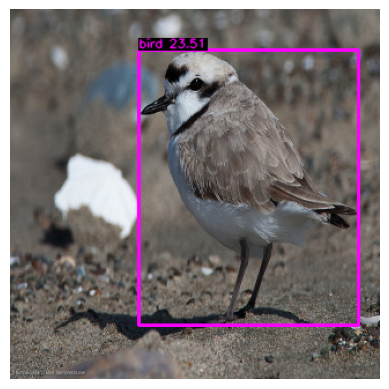

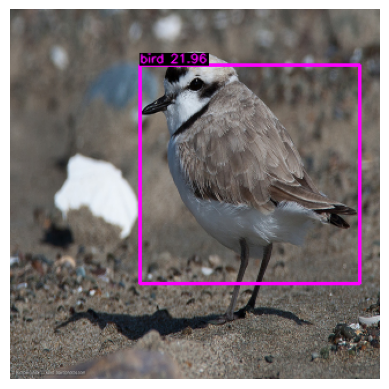

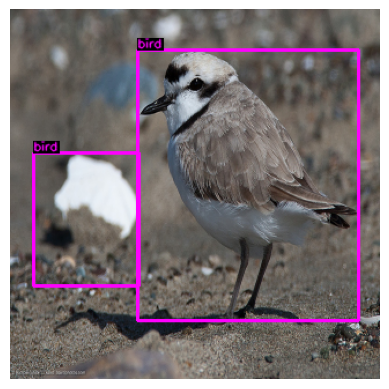

In [194]:
inference = Inference(nclasses=len(classes), stride=torch.tensor([8,16,32]), reg_max=params["reg_max"], device=params['device'])
inference_yolo = InferenceYolo(nclasses=len(classes), stride=torch.tensor([8,16,32]), reg_max=16, device=params['device'])

dataset_bboxes = torch.tensor([])
dataset_cls = torch.tensor([])
pred_output = []

with torch.no_grad():
    for i, (image, bboxes, category_ids, depths) in enumerate(dataloader['val'], start=1):
        
        dataset_bboxes = torch.cat([dataset_bboxes, bboxes.to('cpu')], dim=0)
        dataset_cls = torch.cat([dataset_cls, category_ids.to('cpu')], dim=0)
        
        batch = {'batch_idx' : image.to(params['device'], non_blocking=True), 
                 'cls' : category_ids.to(params['device'], non_blocking=True), 
                 'bboxes' : bboxes.to(params['device'], non_blocking=True),
                 'depths' : depths.to(params['device'], non_blocking=True)}
        
        preds = trained_model(batch['batch_idx'])
        y = inference(preds)
        output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.4, max_det=300, nc=len(classes), multi_label=False)
        
        IND = 0
        
        # view gt image and labels
        print("GT")
        visualize_img(image, bboxes, category_ids, depths, classes, ind=IND)
        
        # view DOD prediction
        print("DOD")
        visualize_pred(image, output, classes, ind=IND)
        
        _, preds = yolomodel(batch['batch_idx'])
        y = inference_yolo(preds)
        output = non_max_suppression(y, conf_thres=0.15, iou_thres=0.4, max_det=300, nc=len(classes), multi_label=False)
        
        # view yolov8n prediction
        print("yolov8n")
        visualize_pred_yolov8n(image, output, classes, ind=IND)
        
        break

## Run Evaluation

In [29]:
metrics_names = ['P','R','mAP50','mAP50-95']
metric_monitor = MetricMonitor()
stream = tqdm(dataloader['val'], ncols=170)
result = {}

inference = Inference(nclasses=len(classes), stride=torch.tensor([8,16,32]), reg_max=params["reg_max"], device=params['device'])
        
dataset_bboxes = torch.tensor([])
dataset_cls = torch.tensor([])
pred_output = []

with torch.no_grad():
    for i, (image, bboxes, category_ids, depths) in enumerate(stream, start=1):
        
        dataset_bboxes = torch.cat([dataset_bboxes, bboxes.to('cpu')], dim=0)
        dataset_cls = torch.cat([dataset_cls, category_ids.to('cpu')], dim=0)
        
        batch = {'batch_idx' : image.to(params['device'], non_blocking=True), 
                 'cls' : category_ids.to(params['device'], non_blocking=True), 
                 'bboxes' : bboxes.to(params['device'], non_blocking=True),
                 'depths' : depths.to(params['device'], non_blocking=True)}
        
        preds = trained_model(batch['batch_idx'])
        y = inference(preds)
        output = non_max_suppression(y, conf_thres=0.001, iou_thres=0.4, max_det=300, nc=len(classes), multi_label=False)

        pred_output.extend(output)
                
        stream.set_description("{metric_monitor}".format(metric_monitor=metric_monitor))
        
validator_aux = v8DetectionValidator(device=params['device'],
                   nclasses=len(classes), 
                   classes=classes)

batch = {'cls' : dataset_cls.to(params['device'], non_blocking=True), 
         'bboxes' : dataset_bboxes.to(params['device'], non_blocking=True)}
result = validator_aux(pred_output, batch, depth=True, plots=True)
print(result)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [03:06<00:00,  1.20s/it]


{'seen': 4952, 'instances': 36335, 'P': 0.4138811666063223, 'R': 0.2596271505330419, 'mAP50': 0.24362511943042797, 'mAP50-95': 0.1237146373364475}


In [63]:
metrics_names = ['P','R','mAP50','mAP50-95']
metric_monitor = MetricMonitor()
stream = tqdm(dataloader['val'], ncols=170)
result = {}

inference_yolo = InferenceYolo(nclasses=len(classes), stride=torch.tensor([8,16,32]), reg_max=16, device=params['device'])
        
dataset_bboxes = torch.tensor([])
dataset_cls = torch.tensor([])
pred_output = []

with torch.no_grad():
    for i, (image, bboxes, category_ids, depths) in enumerate(stream, start=1):
        
        dataset_bboxes = torch.cat([dataset_bboxes, bboxes.to('cpu')], dim=0)
        dataset_cls = torch.cat([dataset_cls, category_ids.to('cpu')], dim=0)
        
        batch = {'batch_idx' : image.to(params['device'], non_blocking=True), 
                 'cls' : category_ids.to(params['device'], non_blocking=True), 
                 'bboxes' : bboxes.to(params['device'], non_blocking=True),
                 'depths' : depths.to(params['device'], non_blocking=True)}
        
        _, preds = yolomodel(batch['batch_idx'])
        y = inference_yolo(preds)
        output = non_max_suppression(y, conf_thres=0.001, iou_thres=0.6, max_det=300, nc=len(classes), multi_label=False)

        pred_output.extend(output)
                
        stream.set_description("{metric_monitor}".format(metric_monitor=metric_monitor))
        
validator_aux = v8DetectionValidator(device=params['device'],
                   nclasses=len(classes), 
                   classes=classes)

batch = {'cls' : dataset_cls.to(params['device'], non_blocking=True), 
         'bboxes' : dataset_bboxes.to(params['device'], non_blocking=True)}
result = validator_aux(pred_output, batch, depth=False, plots=True)
print(result)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [02:39<00:00,  1.03s/it]


{'seen': 4952, 'instances': 36335, 'P': 0.593998018442992, 'R': 0.3975250963583198, 'mAP50': 0.4286038906662618, 'mAP50-95': 0.29388189380304286}
